# **Machine learning model**

## Objectives

* Train machine learning model

## Inputs

* Cleaned data - network-intrusions-clean.csv 

## Outputs

* Trained model, model metrics, feature importance, training curves


---

# Load libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score


# Load and Explore data

In [2]:
df = pd.read_csv("../data/clean/network-intrusions-clean.csv")
print(df.shape)

(25192, 41)


# Preprocessing

Examine the distribution of the target variable (class) in our dataset. The value_counts() method returns the absolute count of each unique class value (normal vs. anomaly), helping us understand how many instances of each type exist in the dataset. The second part uses value_counts(normalize=True) multiplied by 100 to display the same information as percentages

In [3]:
# Count of each class
print(df['class'].value_counts())
print()

# Percentage of each class
print(df['class'].value_counts(normalize=True) * 100)

class
normal     13449
anomaly    11743
Name: count, dtype: int64

class
normal     53.385996
anomaly    46.614004
Name: proportion, dtype: float64


To make the model training more efficient and manageable given the size of the dataset we randomly sample 10,000 rows instead of loading the entire file. This reduces memory usage and speeds up experimentation while still providing a representative subset of the data.

Also, we balance the classes 50:50 to ensure the model learns equally from both the majority and minority classes, preventing bias toward the more frequent class and improving the model’s ability to detect rare events.

In [4]:
n_samples = 10000
df = df.groupby('class', group_keys=False).apply(
    lambda x: x.sample(
        n=min(len(x), n_samples // df['class'].nunique()), 
        random_state=42
    )
)
df.shape

(10000, 41)

Confirm new balance

In [5]:
# Count of each class
print(df['class'].value_counts())
print()

# Percentage of each class
print(df['class'].value_counts(normalize=True) * 100)

class
anomaly    5000
normal     5000
Name: count, dtype: int64

class
anomaly    50.0
normal     50.0
Name: proportion, dtype: float64


Printing comprehensive summary table of all dataset columns to provide a quick overview of the data structure and characteristics. It iterates through each column and collects key information including the data type, number of non-null values, count of unique values and a sample of the actual values.

In [6]:
# Summary table of all columns
summary_data = []

for col in df.columns:
    dtype = df[col].dtype
    n_unique = df[col].nunique()
    non_null = df[col].notna().sum()
    sample = df[col].unique()[:3]
    sample_str = str(sample).replace('\n', ' ')[:50] + '...' if len(str(sample)) > 50 else str(sample)
    
    row = {
        'Column': col,
        'Type': dtype,
        'Non-Null': non_null,
        'Unique': n_unique,
        'Sample': sample_str
    }
    
    if dtype in ['int64', 'float64']:
        row['Min'] = df[col].min()
        row['Max'] = df[col].max()
        row['Mean'] = round(df[col].mean(), 2)
    else:
        row['Min'] = '-'
        row['Max'] = '-'
        row['Mean'] = '-'
    
    summary_data.append(row)

# Create DataFrame and display
summary_df = pd.DataFrame(summary_data)
summary_df

,Column,Type,Non-Null,Unique,Sample,Min,Max,Mean
0,duration,int64,10000,322,[ 0 37815 1],0,42862,278.41
1,protocol_type,object,10000,3,['udp' 'icmp' 'tcp'],-,-,-
2,service,object,10000,64,['private' 'eco_i' 'http'],-,-,-
3,flag,object,10000,10,['SF' 'S0' 'RSTR'],-,-,-
4,src_bytes,int64,10000,970,[1 8 0],0,5135678,9231.44
5,dst_bytes,int64,10000,2068,[ 0 2449 8314],0,5150180,2781.28
6,land,int64,10000,2,[0 1],0,1,0.0
7,wrong_fragment,int64,10000,3,[0 1 3],0,3,0.03
8,urgent,int64,10000,1,[0],0,0,0.0
9,hot,int64,10000,15,[ 0 28 2],0,30,0.17


Although several columns in the dataset contain mostly zero values, we choose not to drop them because the rare non-zero entries can carry important signals of anomalous behavior. In the context of network intrusion detection, these sparse values often represent unusual or suspicious activity, which is exactly what the model needs to learn to detect. Removing these columns could result in losing critical information for identifying anomalies, so they will be retained in the feature set to ensure the model captures these rare but meaningful patterns.

In [7]:
# Analyze distribution of rare values across classes
# Select columns that are mostly zeros (sparse columns)
sparse_columns = []

for col in df.select_dtypes(include=['int64', 'float64']).columns:
    zero_count = (df[col] == 0).sum()
    zero_percentage = (zero_count / len(df)) * 100
    if zero_percentage > 80:  # Columns with more than 80% zeros
        sparse_columns.append(col)

print(f"Found {len(sparse_columns)} sparse columns (>80% zeros)\n")

# Create cross-tabulations for sparse columns
for col in sparse_columns[:10]:  # Show first 10 to avoid too much output
    print(f"\n{'='*60}")
    print(f"Column: {col}")
    print(f"{'='*60}")
    
    # Create binary indicator: 0 vs non-zero
    df[f'{col}_nonzero'] = (df[col] != 0).astype(int)
    
    # Cross-tabulation
    crosstab = pd.crosstab(
        df[f'{col}_nonzero'], 
        df['class'], 
        margins=True,
        normalize='columns'
    ) * 100
    
    print(crosstab.round(2))
    
    # Check if there are any non-zero values before trying to access
    if 1 in crosstab.index:
        print(f"\nNon-zero percentage in normal: {crosstab.loc[1, 'normal']:.2f}%")
        print(f"Non-zero percentage in anomaly: {crosstab.loc[1, 'anomaly']:.2f}%")
    else:
        print("\nThis column has NO non-zero values in the sample.")
    
    # Clean up temporary column
    df.drop(f'{col}_nonzero', axis=1, inplace=True)

Found 18 sparse columns (>80% zeros)


Column: duration
class             anomaly  normal    All
duration_nonzero                        
0                    96.9    88.0  92.45
1                     3.1    12.0   7.55

Non-zero percentage in normal: 12.00%
Non-zero percentage in anomaly: 3.10%

Column: land
class         anomaly  normal    All
land_nonzero                        
0               99.98   100.0  99.99
1                0.02     0.0   0.01

Non-zero percentage in normal: 0.00%
Non-zero percentage in anomaly: 0.02%

Column: wrong_fragment
class                   anomaly  normal   All
wrong_fragment_nonzero                       
0                          98.0   100.0  99.0
1                           2.0     0.0   1.0

Non-zero percentage in normal: 0.00%
Non-zero percentage in anomaly: 2.00%

Column: urgent
class           anomaly  normal    All
urgent_nonzero                        
0                 100.0   100.0  100.0

This column has NO non-zero values in the sampl

urgent: always zero.- drop it:

In [8]:
df.drop(columns='urgent', inplace=True)

# Encoding

In [9]:
categorical_cols = df.select_dtypes(include=['object']).columns

# Print each categorical column and its unique values
for col in categorical_cols:
    print(f"Column: {col}")
    print(df[col].unique())
    print('-' * 40)

Column: protocol_type
['udp' 'icmp' 'tcp']
----------------------------------------
Column: service
['private' 'eco_i' 'http' 'hostnames' 'netbios_dgm' 'telnet' 'ecr_i'
 'courier' 'finger' 'link' 'gopher' 'ftp' 'auth' 'name' 'ftp_data'
 'daytime' 'pop_3' 'whois' 'exec' 'http_443' 'other' 'supdup' 'discard'
 'pop_2' 'vmnet' 'nntp' 'Z39_50' 'csnet_ns' 'time' 'bgp' 'ldap' 'ssh'
 'efs' 'klogin' 'uucp' 'sql_net' 'ctf' 'mtp' 'systat' 'kshell' 'iso_tsap'
 'domain' 'netbios_ns' 'nnsp' 'smtp' 'uucp_path' 'imap4' 'login' 'sunrpc'
 'netstat' 'netbios_ssn' 'echo' 'printer' 'shell' 'rje' 'remote_job'
 'pm_dump' 'X11' 'domain_u' 'urp_i' 'IRC' 'ntp_u' 'urh_i' 'red_i']
----------------------------------------
Column: flag
['SF' 'S0' 'RSTR' 'REJ' 'RSTO' 'SH' 'S2' 'RSTOS0' 'S1' 'S3']
----------------------------------------
Column: class
['anomaly' 'normal']
----------------------------------------
Column: service_category
['Other' 'System_Infrastructure' 'Web' 'Network_Services' 'Remote_Access'
 'Email

In [10]:
# 1. Label encode target
df['class'] = df['class'].map({'normal': 0, 'anomaly': 1})

# 2. Group rare services before encoding
service_counts = df['service'].value_counts()
rare_services = service_counts[service_counts < 50].index
df['service'] = df['service'].replace(rare_services, 'Other')

# 3. One-hot encode all categoricals at once
categorical_cols = ['protocol_type', 'service', 'flag', 'service_category']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Data split

In [11]:
# 1. Separate features and target
X = df.drop(columns=['class'])  # all columns except target
y = df['class']                 # target column

# 2. Train-test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (8000, 81)
Test set shape: (2000, 81)


# Train model

In [12]:

# 1. Initialize the model
rf = RandomForestClassifier(
    n_estimators=100,   # number of trees
    max_depth=None,     # allow full growth
    random_state=42,
    n_jobs=-1           # use all cores
)

# 2. Train the model
rf.fit(X_train, y_train)

# 3. Make predictions
y_pred = rf.predict(X_test)

# 4. Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9985

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Confusion Matrix:
 [[1000    0]
 [   3  997]]


- The model is able to distinguish normal vs anomaly almost perfectly.

- The few misclassifications (3 false negatives) are very small and likely due to borderline cases in the data.

- This indicates your preprocessing, feature selection, and balancing worked very well.

# Evaluation

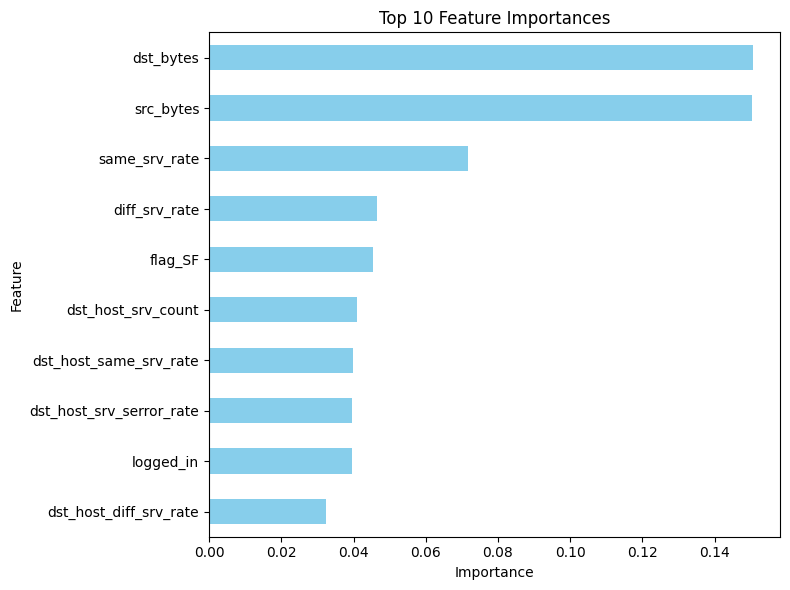

In [13]:
# 1. Create a Series with feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)

# 2. Sort descending
feature_importances = feature_importances.sort_values(ascending=True)  # ascending=True for horizontal bar chart

# 3. Plot top 10
top_n = 10
plt.figure(figsize=(8,6))
feature_importances.tail(top_n).plot(kind='barh', color='skyblue')
plt.title(f'Top {top_n} Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

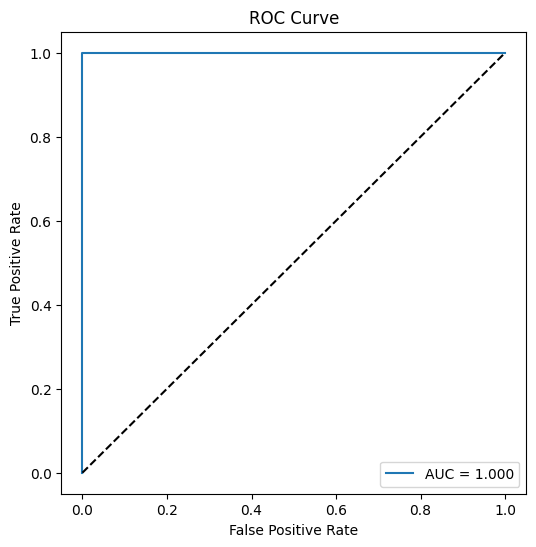

In [14]:
y_prob = rf.predict_proba(X_test)[:,1]  # probability for class 1 (anomaly)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Save model

Section 1 content

---

# Section 2

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---